# HackerNews data analysis with Spark

This notebook analyses a dataset of submitted HackerNews posts using Spark (pyspark). 

There are corresponding functions in the `spark_rdd.py` file. Having standalone functions is a good way to automate reporting of the different metrics in a prouction environment.

Start by importing some of the libraries you will need.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
print(sc)
print("Ready to go!")
%matplotlib inline

<SparkContext master=local[*] appName=pyspark-shell>
Ready to go!


In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

The file has one JSON entry per line. In order to make accessing it easier, first turn each entry as a dictionary and use `persist()` to cache the resulting RDD. 

In [3]:
dataset_json = sc.textFile("data/HNStories-smaller.json.gz")

In [4]:
dataset = dataset_json.map(lambda x: json.loads(x))
dataset.persist()

PythonRDD[2] at RDD at PythonRDD.scala:48

Spark has many helper functions which are useful. You can view them at [http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

### Function `count_elements_in_dataset`

Lets start with some initial analysis. 

**How many elements are in your datasets?**


In [5]:
print("dataset count {:,}".format(dataset.count()))

dataset count 987,523


### Function `get_first_element`

**What does the first element look like? Assign the result to a variable called `first` **


In [6]:
first = dataset.first()
first

{'author': 'TuxLyn',
 'created_at': '2014-05-29T08:25:40Z',
 'created_at_i': 1401351940,
 'num_comments': 0,
 'objectID': '7815290',
 'points': 1,
 'title': 'DuckDuckGo Settings',
 'url': 'https://duckduckgo.com/settings'}

In [7]:
set(first)

{'author',
 'created_at',
 'created_at_i',
 'num_comments',
 'objectID',
 'points',
 'title',
 'url'}

### Function `get_all_attributes`

Each element is a dictionary of attributes and their values for a post. 
**Find the set of all attributes used throughout the RDD**
The function `dictionary.keys()` gives you the list of attributes of a dictionary.

In [8]:
%%time
kset2 = dataset.flatMap(lambda x: x.keys()).distinct()
print(kset2.take(20))

['author', 'created_at', 'created_at_i', 'num_comments', 'objectID', 'points', 'title', 'url', 'story_text', 'story_id']
Wall time: 7.91 s


### Function `get_elements_w_same_attributes`

We see that there are more attributes than just the one used in the first element. Can you filter the dataset to keep only elements that have the same set of attributes as the first element?
Hint: you might want to write a function that compares attributes for two elements and apply it on your dataset.

In [9]:
first_keys = first.keys()
first_keys

dict_keys(['author', 'created_at', 'created_at_i', 'num_comments', 'objectID', 'points', 'title', 'url'])

In [10]:
first_set = set(first)

In [11]:
def compare_keys(elt):
    return set(elt) == first_set

In [12]:
f_set = dataset.filter(lambda x: compare_keys(x))

In [13]:
f_set = dataset.filter(compare_keys)

How many elements did you find?

In [14]:
print("number of elemets with same set of keys = {:,}".format(f_set.count()))

number of elemets with same set of keys = 848,238


### How many posts through time

The field `created_at_i` is very useful, it gives you a UNIX timestamp of the time at which the file was created. The following function lets you extract a time from a timestamp.

In [15]:
def extract_time(timestamp):
    return dt.utcfromtimestamp(timestamp)

### Function `get_min_max_timestamps`

**Find the minimum and maximum timestamps in the RDD and call them `min_time` and `max_time`.** 
These correspond to the first and last post, when did they occur? For the function `get_min_max_timestamps` you need to return min_time and max_time given a dataset

In [16]:
print("2014-05-29T08:25:40Z")
print(extract_time(1401351940))

2014-05-29T08:25:40Z
2014-05-29 08:25:40


In [17]:
# Find the minimum timestamp
min_timestamp = dataset.map(lambda x: x['created_at_i']).min()
print(min_timestamp)

1160418111


In [18]:
# Find the max timestamp
max_timestamp = dataset.map(lambda x: x['created_at_i']).max()
print(max_timestamp)

1401351940


### Function `get_number_of_posts_per_bucket`

Now lets analyse how many elements through time. The following function assigns a record to one of 200 "buckets" of time. **Use it to count the number of elements that fall within each bucket and call the result `bucket_rdd`.** The result should be such that `buckets` below generates the corresponding output. If you want to use this function in your `spark_rdd.py` you will need to redefine it in the file.

In [19]:
def get_bucket(rec, min_timestamp, max_timestamp):
    interval = (max_timestamp - min_timestamp + 1) / 200.0
    return int((rec['created_at_i'] - min_timestamp)/interval)

In [20]:
rec_test = {'author': 'TuxLyn',
 'created_at': '2014-05-29T08:25:40Z',
 'created_at_i': 1401351940,
 'num_comments': 0,
 'objectID': '7815290',
 'points': 1,
 'title': 'DuckDuckGo Settings',
 'url': 'https://duckduckgo.com/settings'}

In [21]:
type(min_timestamp)

int

In [22]:
get_bucket(rec_test, min_timestamp, max_timestamp)

199

In [23]:
half_buckets_rdd = dataset.map(lambda x: (get_bucket(x, min_timestamp, max_timestamp), 1)).groupByKey()
buckets_rdd = half_buckets_rdd.map(lambda pair: (pair[0], len(pair[1])))

In [24]:
buckets = sorted(buckets_rdd.collect())

In [25]:
print("type(buckets) ", type(buckets), ", len(buckets) ", len(buckets))

type(buckets)  <class 'list'> , len(buckets)  176


We can then use this to plot the number of submitted posts over time.

In [26]:
interval = (max_timestamp - min_timestamp + 1) / 200.0
bs = [dt.utcfromtimestamp(x[0]*interval + min_timestamp) for x in buckets]
ts = [x[1] for x in buckets]

In [27]:
print(type(bs), len(bs))
print(type(ts), len(ts))

<class 'list'> 176
<class 'list'> 176


In [28]:
display(bs[0:3])

[datetime.datetime(2006, 10, 9, 18, 21, 51),
 datetime.datetime(2006, 12, 4, 12, 53, 7, 600000),
 datetime.datetime(2007, 2, 12, 6, 2, 13, 350000)]

In [29]:
display(ts[0:10])

[36, 1, 199, 579, 561, 161, 791, 808, 713, 551]

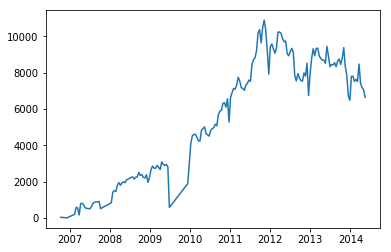

In [30]:
plt.plot(bs, ts)

### Function `get_number_of_posts_per_hour`

The following function gets the hour of the day at which a post was submitted. **Use it to find the number of posts submitted at each hour of the day.** The value of `hours_buckets` should match the one printed below.

In [31]:
def get_hour(rec):
    t = dt.utcfromtimestamp(rec['created_at_i'])
    return t.hour

In [32]:
get_hour(rec_test)

8

In [33]:
half_hours_buckets_rdd = dataset.map(lambda x: (get_hour(x), 1)).groupByKey()
hours_buckets_rdd = half_hours_buckets_rdd.map(lambda pair: (pair[0], len(pair[1])))

In [34]:
hours_buckets = sorted(hours_buckets_rdd.collect())

In [35]:
hours_buckets[0:24:23]

[(0, 32465), (23, 36033)]

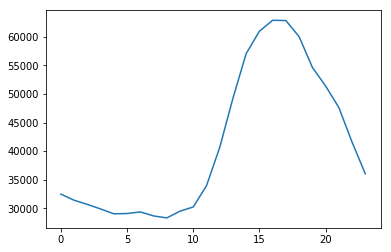

In [36]:
hrs = [x[0] for x in hours_buckets]
sz = [x[1] for x in hours_buckets]
plt.plot(hrs, sz)

### Function `get_score_per_hour`

The number of points scored by a post is under the attribute `points`. **Use it to compute the average score received by submissions for each hour.**

In [37]:
half_scores_p_hr_rdd = dataset.map(lambda x: (get_hour(x), x['points'])).groupByKey()
scores_per_hour_rdd = half_scores_p_hr_rdd.map(lambda pair: (pair[0], sum(pair[1])/len(pair[1])))

In [38]:
scores_per_hour = sorted(scores_per_hour_rdd.collect())

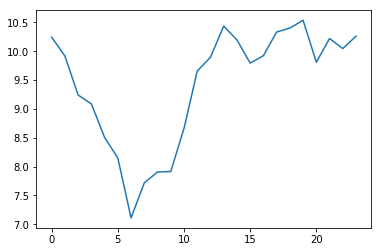

In [39]:
hrs = [x[0] for x in scores_per_hour]
sz = [x[1] for x in scores_per_hour]
plt.plot(hrs, sz)

### Function `get_proportion_of_scores`

It may be more useful to look at sucessful posts that get over 200 points. **Find the proportion of posts that get above 200 points per hour.**

In [40]:
half_prop_scores_rdd = dataset.map(lambda x: (get_hour(x), x['points'])).groupByKey()
prop_per_hour_rdd = half_prop_scores_rdd.map(lambda pair: (pair[0], sum(i>200 for i in pair[1])/len(pair[1])))

In [41]:
prop_per_hour = sorted(prop_per_hour_rdd.collect())

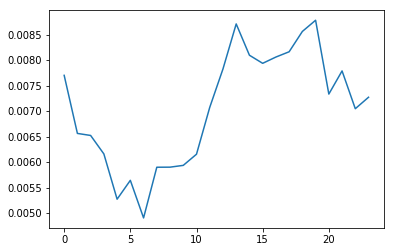

In [42]:
hrs = [x[0] for x in prop_per_hour]
sz = [x[1] for x in prop_per_hour]
plt.plot(hrs, sz)

### Function `get_proportion_of_success`

The following function lists the word in the title. **Use it to count the number of words in the title of each post, and look at the proportion of successful posts for each title length.**

If an element does not have a title, it should count it as a length of 0.

In [43]:
import re
def get_words(line):
    return re.compile('\w+').findall(line)
# note: use re.compile(r'\w+') in .py file

In [44]:
get_words(rec_test['title'])

['DuckDuckGo', 'Settings']

In [45]:
half_title_rdd = dataset.map(lambda x: (len(get_words(x['title'])) if 'title' in x else 0, x['points'])).groupByKey()
prop_per_title_length_rdd = half_title_rdd.map(lambda pair: (pair[0], sum(i>200 for i in pair[1])/len(pair[1])))

In [46]:
prop_per_title_length_rdd.take(5)

[(2, 0.009607884847195632),
 (5, 0.0085),
 (8, 0.006197307964435806),
 (10, 0.006581222194048085),
 (11, 0.006841710427606902)]

In [47]:
prop_per_title_length = sorted(prop_per_title_length_rdd.collect())

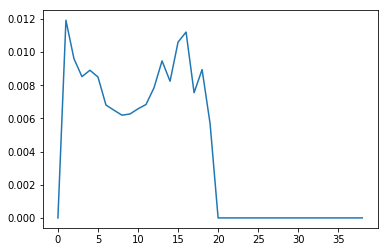

In [48]:
hrs = [x[0] for x in prop_per_title_length]
sz = [x[1] for x in prop_per_title_length]
plt.plot(hrs, sz)

### Function `get_title_length_distribution`

Lets compare this with the distribution of number of words. **Count for each title length the number of submissions with that length.**

In [49]:
half_subs_rdd = dataset.map(lambda x: (len(get_words(x['title'])) if 'title' in x else 0, 1)).groupByKey()
submissions_per_length_rdd = half_subs_rdd.map(lambda pair: (pair[0], sum(pair[1])))

In [50]:
submissions_per_length_rdd.take(3)

[(2, 28206), (5, 98000), (8, 117309)]

In [51]:
submissions_per_length = sorted(submissions_per_length_rdd.collect())

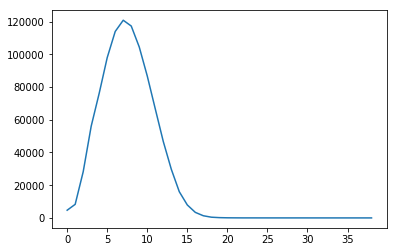

In [52]:
hrs = [x[0] for x in submissions_per_length]
sz = [x[1] for x in submissions_per_length]
plt.plot(hrs, sz)

Looks like most people are getting it wrong!

### Optional

For this task, you will need a new function: `takeOrdered()`. Like `take()` it collects elements from an RDD. However, it can be applied to take the smallest elements. For example, `takeOrdered(10)` returns the 10 smallest elements. Furthermore, you can pass it a function to specify the way in which the elements should be ordered. For example, `takeOrdered(10, lambda x: -x)` will return the 10 largest elements.

The function below extracts the url domain out of a record. **Use it to count the number of distinct domains posted to.**

In [53]:
from urllib.parse import urlparse
def get_domain(rec):
    url = urlparse(rec['url']).netloc
    if url[0:4] == 'www.':
        return url[4:]
    else:
        return url
print(get_domain(dataset.take(1)[0]))

duckduckgo.com


In [54]:
# Count the number of distinct domains
domains = dataset.map(lambda x: 'example.com' if 'url' not in x else get_domain(x)).distinct().count()
domains

177728

Using `takeOrdered()` find the 25 most popular domains posted to.

In [55]:
pop_domains_rdd = dataset.map(lambda x: ('no domain' if 'url' not in x else get_domain(x), 1)).groupByKey()
top25 = pop_domains_rdd.map(lambda pair: (pair[0], sum(pair[1]))).takeOrdered(25, lambda x: -x[1])

In [56]:
print(top25)

[('no domain', 60536), ('techcrunch.com', 16794), ('youtube.com', 13376), ('github.com', 12611), ('nytimes.com', 10579), ('arstechnica.com', 7889), ('wired.com', 6214), ('bbc.co.uk', 5177), ('medium.com', 4804), ('mashable.com', 4435), ('businessinsider.com', 4121), ('thenextweb.com', 4049), ('online.wsj.com', 4027), ('venturebeat.com', 4026), ('en.wikipedia.org', 3967), ('readwriteweb.com', 3846), ('forbes.com', 3826), ('gigaom.com', 3652), ('theverge.com', 3262), ('news.cnet.com', 3179), ('theatlantic.com', 2968), ('guardian.co.uk', 2952), ('economist.com', 2840), ('washingtonpost.com', 2522), ('engadget.com', 2451)]


<BarContainer object of 25 artists>

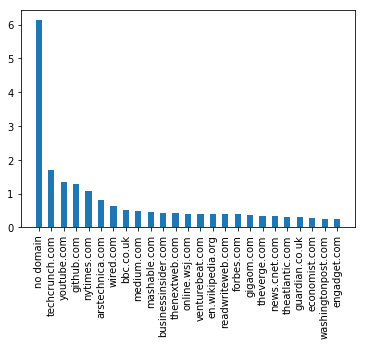

In [57]:
index = np.arange(25)
labels = [x[0] for x in top25]
counts = np.array([x[1] for x in top25]) * 100.0/dataset.count()
plt.xticks(index,labels, rotation='vertical')
plt.bar(index, counts, 0.5)